In [1]:
## parameters for experiment
N_BLOCK = 5
#LR = 0.00001
LR = 0.001

OUTPUT_DIR = '20251016-FocalLoss-Experiment'
RANDOM_SEED = 42

IN_CHANNEL = 1

AUGMENTED = True
AUGMENTATION  =  30


CROSS_VAL = True
N_SPLIT = 4


#optimization constants
DICE_IMPORTANCE = 1.0
CE_IMPORTANCE = 1.0

In [2]:
## import libraries
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet4
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer
from sklearn.model_selection import StratifiedKFold, train_test_split




2025-10-16 16:47:30.687570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 16:47:31.410415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
## random seed config
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(RANDOM_SEED)

# Set seed for NumPy
np.random.seed(RANDOM_SEED)

# Set seed for PyTorch
torch.manual_seed(RANDOM_SEED)

# If you are using GPU
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [4]:
## cuda and pytorch stats
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [5]:
## file_names_with_prefix
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [6]:
## paths config
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
#date_str = '20241202-Conv1x1-' + str(OUTPUT_DIR)
date_str = OUTPUT_DIR

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/original")
feature_dir = str(root_dir / "img_1006t/feature") 
labeled_dir = str(root_dir / "img_1006t/labeled")

augmented_labeled_dir = str(root_dir / "img_1006t/labelAug")
augmented_data_dir = str(root_dir / "img_1006t/originalAug")
augmented_feature_dir = str(root_dir / "img_1006t/featureAug")


# data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcOriginal")
# feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcFeature") 
# labeled_dir = str(root_dir / "img_1006t/labeled")

# augmented_labeled_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCLabel")
# augmented_data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCOriginal")
# augmented_feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCFeature")

# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []


# for raw_input_img in INPUT:
#     input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
# for raw_val_img in VALIDATION:
#     input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
# for raw_anneal in ANNEALING:
#     annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
# for raw_test in TEST:
#     test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
# print(input_train)
# print(input_name_val)
# print(annealing_input_name)
# print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


# print(len(input_train))

# print(len(input_name_val))
# print(len(test_input_name))
# print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/original
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/feature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20251016-FocalLoss-Experiment
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment


In [7]:
## feature list definition
# 特徴画像の特徴一覧をリストとして取得#
#inputfeature_list = list(map(str, InputFeature))
inputfeature_list = ['CLA_']

# inputfeature_list = ["GRY_", "NML1", "NML2", "NML3", "NML1", "MEA1",
#                      "MEA2", "MED1", "MED2", "NML1", "NGP_", "KNN1",
#                      "KNN2", "BLT1", "BLT2", "UNS1", "UNS2", "UNS3",
#                      "UNS4", "UNS5", "ERO1", "ERO2", "ERO3", "ERO4",
#                      "ERO5", "ERO6", "OPN1", "OPN2", "OPN3", "OPN4",
#                      "OPN5", "CLO1", "CLO2", "CLO3", "CLO4", "CLO5",
#                      "MIN1", "MIN2", "MIN3", "MIN4", "MAX1", "MAX2",
#                      "MAX3", "MAX4", "MRL1", "MRL2", "MRL3", "MRL4",
#                      "RIC_",
#                      ]



# unet only
#inputfeature_list = inputfeature_list[:1]

#inputfeature_list.clear()

#inputfeature_list.append("RIC_")
#print(inputfeature_list)

#inputfeature_list.remove(OUTPUT_DIR[-4:])
# inputfeature_list.remove("TOP1")
# inputfeature_list.remove("TOP2")
# inputfeature_list.remove("TOP3")
# inputfeature_list.remove("TOP4")

# inputfeature_list.remove("SBLX")
# inputfeature_list.remove("SBLY")
# inputfeature_list.remove("SBLM")
# inputfeature_list.remove("SBLD")
# inputfeature_list.remove("SBL1")
# inputfeature_list.remove("SBL2")
# inputfeature_list.remove("SBL3")
# inputfeature_list.remove("SBL4")

# inputfeature_list.remove("LPL1")
# inputfeature_list.remove("LPL2")

# inputfeature_list.remove("LBP1")
# inputfeature_list.remove("LBP2")
# inputfeature_list.remove("LBP3")

# inputfeature_list.remove("SOL_")
# inputfeature_list.remove("OOO_")

# inputfeature_list.remove("CAN1")
# inputfeature_list.remove("CAN2")
# inputfeature_list.remove("CAN3")


# inputfeature_list.remove("FOU1")
# inputfeature_list.remove("FOU2")
# inputfeature_list.remove("FOU3")
# inputfeature_list.remove("FOU4")

# inputfeature_list.remove("SCH1")
# inputfeature_list.remove("SCH2")
# inputfeature_list.remove("SCH3")
# inputfeature_list.remove("SCH4")

# inputfeature_list.remove("ROB1")
# inputfeature_list.remove("ROB2")
# inputfeature_list.remove("ROB3")
# inputfeature_list.remove("ROB4")

# inputfeature_list.remove("MRG1")
# inputfeature_list.remove("MRG2")
# inputfeature_list.remove("MRG3")
# inputfeature_list.remove("MRG4")

# inputfeature_list.remove("BTM1")
# inputfeature_list.remove("BTM2")
# inputfeature_list.remove("BTM3")
# inputfeature_list.remove("BTM4")

# inputfeature_list.remove("DST_")
# inputfeature_list.remove("HOM_")

# for i in range(108):
#     stckd_feature_name = "NGP_" + inputfeature_list[i]
#     inputfeature_list.append(stckd_feature_name)

# for input_feature in inputfeature_list[:]:
#     if not input_feature.startswith("NGP"):
#         inputfeature_list.remove(input_feature)
        


print(inputfeature_list)
feature_num = len(inputfeature_list)


print(feature_num)

['CLA_']
1


In [8]:
## createweightimage read by images
# takes too much memory cuz it loads all images into np array at once


## 重み計算なし
def CreateWeightImage(input_number, augmentation=False):
    print("Creating image arrays...")
    label_dataset = []
    arrDataset = []
    for i in input_number:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/" , f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                    
        label_dataset.append(input_originallabel)

    print("Number of label images:", len(label_dataset))


    
    for i in input_number:
        # changed this part from 100 to 256

        dataset_img =  np.zeros((256, 256, feature_num), dtype=np.float32)
            
            
        for m in range(feature_num):
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/" , str(i), f"{inputfeature_list[m]}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg

        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("Completed creating image arrays:")
    print("Dataset shape ", arrDataset.shape)
    print("Label image shape ", np.shape(label_dataset))
    print()

    return arrDataset, label_dataset


In [9]:
## createweightimagenew read paths only
def CreateWeightImageNew(input_numbers, augmentation=False):
    print("Creating image paths...")
    label_paths = []
    feature_paths = []

    for i in input_numbers:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/", f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        label_paths.append(label_path)

        feature_img_paths = []
        for feature_name in inputfeature_list:
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/", str(i), f"{feature_name}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{feature_name}.png")
            feature_img_paths.append(feature_img_path)

        feature_paths.append(feature_img_paths)

    print(f"Processed {len(label_paths)} label paths and {len(feature_paths)} feature paths.")
    return feature_paths, label_paths


In [10]:
## create weight test example

# input_dataset,label_dataset = CreateWeightImage(input_train)
# input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)



In [11]:
## createweightimageforshow
# # # 重みを基づいて、MC画像を生成する
# # # function for showing MC image
# # # gets 1d array as weight, input_number is image name, and index is directory name for the mc image to save
# def CreateWeightImageforShow(weight, input_number, index):
#     sum_weight = sum(weight)  # Calculate total weight

#     label_dataset = []
#     input_dataset = []
#     dataset_original = []

#     # Read label images
#     for i in input_number:
#         input_originallabel = cv2.imread(labeled_dir + "/" + str(i) + ".png", flags=0)
#         label_dataset.append(input_originallabel)

#     print('Weight image for show, label length = ', len(label_dataset))

#     # Create output directory
#     os.makedirs(test_result_dir + "/weightImage/" + str(index), exist_ok=True)

#     # Generate weighted images
#     for i in input_number:
#         # Create a blank image to store the weighted image, using float type for accumulation
#         dataset_img = np.zeros((256, 256, 3), dtype=np.float32)
#         input_originalimg = cv2.imread(data_dir + "/" + str(i) + ".png")

#         dataset_original.append(input_originalimg)
#         for m in range(feature_num):
#             input_featureimg = cv2.imread(feature_dir + "/" + str(i) + "/" + inputfeature_list[m] + ".png", cv2.IMREAD_GRAYSCALE)
#             # Normalize the feature image
#             normalized_feature_img = cv2.normalize(input_featureimg.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
#             # Accumulate the weighted feature image
#             dataset_img += normalized_feature_img[:, :, None] * (weight[m] / sum_weight)  # Convert 2D array to 3D array

#         # Normalize the accumulated image to the range 0-255
#         dataset_img = cv2.normalize(dataset_img, None, 0, 255, cv2.NORM_MINMAX)
#         output_img = dataset_img.astype(np.uint8)  # Convert to uint8

#         input_dataset.append(output_img)
#         # Write to file
#         cv2.imwrite(f"{test_result_dir}/weightImage/{index}/{i}.png", output_img)

#     return input_dataset, label_dataset


In [12]:
## value extraction for visual mc
# # ## Netron app to extract the weight tensor
# # ## if the conv is 1x1 the tensor has 45 values
# # ## if the conv is 3x3 there are 9 x 45 values so the function averages 9 value into 1 and so on
# def compute_mean_values(input_list):
#     """
#     Compute mean of 3x3 blocks in each channel of the input list.
    
#     Args:
#         input_list (list): A 4D list of shape (1, C, H, W).
        
#     Returns:
#         list: A 1D list of length C containing the mean values for each channel.
#     """
#     # Ensure the input is a 4D list
#     if not isinstance(input_list, list) or len(input_list) != 1:
#         raise ValueError("Expected input list of shape (1, C, H, W)")
    
#     channels = input_list[0]  # Get the channels (C, H, W)
    
#     if not isinstance(channels, list) or not all(isinstance(channel, list) for channel in channels):
#         raise ValueError("Each channel must be a list of 2D lists (H, W).")
    
#     mean_values = []
#     for channel in channels:
#         if not all(isinstance(row, list) for row in channel):
#             raise ValueError("Each channel must contain 2D lists.")
        
#         # Flatten the 2D channel to compute the mean
#         flattened = [value for row in channel for value in row]
#         mean_values.append(sum(flattened) / len(flattened))
    
#     return mean_values


In [13]:
## mc image visualization example
# ### 1X1-1029-23-n1-1
# ### JUST SINGLE VARIATION
# weight_tensor_1x1_1029_23_n1_1_example = [
#     [
#         [
#             [
#                 0.048620592802762985
#                 ...
#     ]
# ]

# input_number = ['N1-1']

# #single
# weight_cn = compute_mean_values(weight_tensor_1x1_1029_23_n1_1)

# weight_cn1 = compute_mean_values(weight_tensor_1x1_1029_36_n1_1)
# weight_cn2 = compute_mean_values(weight_tensor_3x3_1_1029_36_n1_1)
# weight_cn3 = compute_mean_values(weight_tensor_3x3_2_1029_36_n1_1)
# weight_cn4 = compute_mean_values(weight_tensor_5x5_1_1029_36_n1_1)
# weight_cn5 = compute_mean_values(weight_tensor_5x5_2_1029_36_n1_1)

# print(len(weight_cn))
# print(len(weight_cn1))
# print(len(weight_cn2))
# print(len(weight_cn3))
# print(len(weight_cn4))
# print(len(weight_cn5))

# CreateWeightImageforShow(weight_cn, input_number, "single")

# CreateWeightImageforShow(weight_cn1, input_number, "multiple1x1")
# CreateWeightImageforShow(weight_cn2, input_number, "multiple3x3-1")
# CreateWeightImageforShow(weight_cn3, input_number, "multiple3x3-2")
# CreateWeightImageforShow(weight_cn4, input_number, "multiple5x5-1")
# CreateWeightImageforShow(weight_cn5, input_number, "multiple5x5-2")



In [14]:
## mc image visualization example
# weight_tensor = np.load("/home/eric/Documents/cervicalResearchIIP/result_test/20250420-MCU-Net-108/0420_MCU108_fold4_w.npy")

# # initial shape (3, 108, 3, 3) (out_channels, channels, height_convolution, width_convolution)
# # np.mean takes mean value of out_channels
# # [np.newaxis, :] shapes into (1, 108, 3, 3)
# weight_tensor = np.mean(weight_tensor, axis = 0)[np.newaxis, :]
# weight_tensor = weight_tensor.tolist()

# #f1
# #input_number = ["N1-1", "N1-7", "N1-9", "N2-3", "N2-7", "N2-10", "N3-1", "N3-8", "N3-10", "N4-8", "N5-4"]
# #f2
# #input_number = ["N1-2", "N1-5", "N1-10", "N2-4", "N3-2", "N3-4", "N3-5", "N3-9", "N4-3", "N4-9", "N5-2"]
# #f3
# #input_number = ["N1-3", "N1-4", "N1-10", "N2-1", "N2-5", "N2-8", "N3-3", "N3-7", "N4-4", "N4-5", "N4-6", "N5-1", "N5-6"]
# #f4
# input_number = ["N1-6", "N1-8", "N2-2", "N2-6", "N2-9", "N3-6", "N4-1", "N4-2", "N4-7", "N5-3", "N5-5"]

# # weight_tensor_converted = weight_tensor[0].tolist()

# # weight_tensor_dv1 = [weight_tensor_converted]
# # # print(weight_tensor_dv1.shape)
# weight_cn  = compute_mean_values(weight_tensor)

# CreateWeightImageforShow(weight_cn, input_number, "fold4")

In [15]:
## minor irrelevant function
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [16]:
## preprocess and postprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
    #img = img * 255.0 commented as the labels are from 0 to 11 in my case
    img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
    # If batch_size > 1, you may need to loop through each batch and save them separately
    # If batch_size == 1, you can remove the batch dimension to save a single image

    # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
    #print("in post")
    #print(np.unique(img))


    img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
    # img = re_normalize(img)  # Scale it to the range [0-255]

    # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
    # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
    # If C == 1, you can further reduce dimensions -> [H, W]
    if img.shape[0] == 3:  # [C, H, W]
        img = np.transpose(img, (1, 2, 0))  # [H, W, C]
        img = img[:, :, ::-1]  # Convert RGB to BGR
    elif img.shape[0] == 1:  # [C, H, W]
        img = np.squeeze(img, 0)  # [H, W]
    return img


In [ ]:
## learn_ea function training logic
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet5
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, type_number, fold=0):
    print("*************************Training*************************")
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用

    #for direct loading
    dataset_train2 = SegmentationDataSet0(
                                        #inputs=dataset_original,
                                        inputs=input_dataset,
                                        targets=label_dataset,
                                        transform=transforms_training)
    # for lazy loading
    # dataset_train2 = SegmentationDataSet5(
    #                                     #inputs=dataset_original,
    #                                     feature_paths=input_dataset,
    #                                     label_paths=label_dataset,
    #                                     feature_num = IN_CHANNEL,
    #                                     transform=transforms_training)

    # dataloader training
    #rearranged in custom order so shuffle is false in normal case: true
    dataloader_training2 = DataLoader(dataset=dataset_train2,
                                     batch_size = 2,
                                     shuffle=True)
                                     #num_workers=4,
                                     #pin_memory=True)
    #もとはシャッフルtrue


    batch = next(iter(dataloader_training2))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # dataset training
    dataset_val = SegmentationDataSet0(inputs=input_dataset_val,
                                        targets=label_dataset_val,
                                        transform=transforms_val)
    #書き換え箇所
    dataloader_val = DataLoader(dataset=dataset_val,
                                     batch_size = 2,
                                     shuffle=False)
                                     #num_workers=4, # for faster training loads next batch while training
                                     #pin_memory=True)  # for faster training, keeps data in pinned memory
    
    
    
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss
    from customLoss import DiceCELoss
    from customLoss import DiceLoss
    from customLoss import ExponentialLogCE_DiceLoss
    from customLoss import EnsembleInspiredLoss
    from customLoss import ConfusionPenaltyLoss
    from customLoss import CombinedLoss

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = IN_CHANNEL
    outChannels = 11
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=32,
                 activation='relu',
                 normalization='instance',
                 conv_mode='same',
                 dim=2,
                 ).to(device)

    ### Later for experimenting
    #from originalUNet import Original_UNet
    #model = Original_UNet()

    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)

    from customLoss import MultiClassFocalLoss
    
    #criterion = MultiClassFocalLoss()
    
    
    #criterion = CombinedLoss()
    #criterion.to(device=device)

    #loss function
    #criterion = ConfusionPenaltyLoss(num_classes=11)
    # pytorch cross entropy loss function
    
    criterion = torch.nn.CrossEntropyLoss(ignore_index = 0)
    
    #criterion = EnsembleInspiredLoss()
    
    #custom dice loss
    #criterion = DiceLoss()
    
    #custom combination loss of dice and cross entropy
    # 40 60 ratio
    #criterion = DiceCELoss(dice_weight = DICE_IMPORTANCE, ce_weight = CE_IMPORTANCE)
    
    # pytorch bce loss 
    # criterion = BCEWithLogitsLoss()
    
    # custom combination log exp loss of dice and cross entropy
    # requires segmentation class number
    #criterion = ExponentialLogCE_DiceLoss(num_class = 11)

    #optimizer
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-7)
    
    #Your case (instability)1e-4 or 3e-4
    # #Small dataset1e-4
    # Large dataset3e-4 to 1e-3
    # Transfer learning1e-5 to 1e-4
    # Training from scratch3e-4
    # Loss oscillating/spikingReduce current LR by 10x
    # oss not decreasingIncrease LR or check other issues
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoader=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoader=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True)
  
    print("=======start training======")
    
    # start training
    training_losses, validation_losses, lr_rates, learning_curve = trainer.run_trainer()
    
    #logging to csv
    assert len(training_losses) == len(validation_losses) == len(lr_rates), \
        "Lengths of training, validation losses, and learning rates must match."

    # Create dataframe
    df = pd.DataFrame({
        "Epoch": list(range(1, len(training_losses) + 1)),
        "Training_Loss": training_losses,
        "Validation_Loss": validation_losses,
        "Learning_Rate": lr_rates
    })

    # Save to CSV
    df.to_csv(test_result_dir + "/log.csv")
    
    print("***************************")

    learning_curve.savefig(test_result_dir + "/learning-curve.png")
    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"model_fold_{fold}.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")
    #torch.cuda.empty_cache()
    

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    output = [predict(img, model, preprocess, postprocess, device) for img in images]


    for i in range(len(input_name_val)):
        if(type_number == 0):
            cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 1):
            cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 2):
            cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [18]:
## dice calculation
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [19]:

## mConv_predict test function
import statistics
from denseCRF import noiseReduction
# device
def mConv_predict(test_input_name, fold=0):
    print("*************************************Test*************************************")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        print("Using CPU instead of GPU")
        torch.device('cpu')

    model = UNet(in_channels=IN_CHANNEL,  # check the parameters
                out_channels=11,
                n_blocks=N_BLOCK,
                start_filters=32,
                activation='relu',
                normalization='instance', #use instance when "batch" size is less than 10? batch
                conv_mode='same',
                dim=2).to(device)

    model_dir = os.path.join("model", date_str)
    print("model_dir = ", model_dir)
    model_path = os.path.join(model_dir, f"model_fold_{fold}.pt") # load the model
    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)

    model.eval()

    # create test dataset
    test_input_dataset, _ = CreateWeightImage(test_input_name)
 

    # convert to torch
    test_input_tensor = torch.from_numpy(test_input_dataset).float().to(device)


    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict
    output = [predict(img, model, preprocess, postprocess, device) for img in test_input_dataset]


    plot_output_img = list()
    
    
    fold_dir = os.path.join(test_result_dir, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    
    # save images
    for i, output_img in enumerate(output):
        #for checking the unique values of the result label
        labels = np.unique(output_img)

        output_image_path = os.path.join(fold_dir, f"{test_input_name[i]}.png")
        cv2.imwrite(output_image_path, output_img)
        
        # old writing when there was no stratifiedkfold
        # cv2.imwrite(os.path.join(test_result_dir, f"{test_input_name[i]}.png"), output_img)  # 根据需要调整文件路径和命名

        #print(labels)
        plot_output_img.append(output_img)


    Dice = cal_DiceMulitple(fold_dir, test_input_name)
    df = pd.DataFrame(Dice)
    df = df.T
    df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    
    postCRF = noiseReduction(output, test_input_name, labeled_dir, fold_dir, 0.8)
    
    DiceCRF = cal_DiceMulitple( fold_dir + "/crf", test_input_name)
    dfCRF = pd.DataFrame(DiceCRF)
    dfCRF = dfCRF.T
    dfCRF.to_csv(test_result_dir + "/CRFDice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    

    



['N1-1' 'N1-2' 'N1-3' 'N1-4' 'N1-5' 'N1-6' 'N1-7' 'N1-8' 'N1-9' 'N1-10'
 'N2-1' 'N2-2' 'N2-3' 'N2-4' 'N2-5' 'N2-6' 'N2-7' 'N2-8' 'N2-9' 'N2-10'
 'N3-1' 'N3-2' 'N3-3' 'N3-4' 'N3-5' 'N3-6' 'N3-7' 'N3-8' 'N3-9' 'N3-10'
 'N4-1' 'N4-2' 'N4-3' 'N4-4' 'N4-5' 'N4-6' 'N4-7' 'N4-8' 'N4-9' 'N5-1'
 'N5-2' 'N5-3' 'N5-4' 'N5-5' 'N5-6']
['N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N2' 'N2' 'N2' 'N2'
 'N2' 'N2' 'N2' 'N2' 'N2' 'N2' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3'
 'N3' 'N3' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N5' 'N5' 'N5'
 'N5' 'N5' 'N5']
Cross validation: True
Fold: 1 out of 4
Augmentation: True
Augmentation amount: 30
Training: Total of 22 cases.
['N4-9' 'N3-1' 'N2-8' 'N3-10' 'N5-5' 'N2-3' 'N4-3' 'N1-7' 'N1-10' 'N1-1'
 'N3-8' 'N2-6' 'N5-4' 'N2-4' 'N4-4' 'N1-9' 'N1-3' 'N3-5' 'N5-3' 'N3-6'
 'N4-8' 'N2-7']
Validation: Total of 11 cases.
['N4-5' 'N5-2' 'N2-10' 'N1-8' 'N3-4' 'N4-2' 'N3-7' 'N4-7' 'N2-5' 'N1-5'
 'N2-9']
Test: Total of 12 cases.
['N1-2' 'N1-4' 'N1-6' 'N2-1' 'N2-2' '

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.1366988967313911
val_losses 0.11768686509493625
lr 0.0001
Validation loss decreased (inf --> 0.117687).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.11332483158418627
val_losses 0.10948886559768156
lr 0.0001017999999999998
Validation loss decreased (0.117687 --> 0.109489).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.10533836569749948
val_losses 0.1016395497954253
lr 0.00010360000000000001
Validation loss decreased (0.109489 --> 0.101640).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.09741904803297737
val_losses 0.09365183598164356
lr 0.00010539999999999981
Validation loss decreased (0.101640 --> 0.093652).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.08959493693528753
val_losses 0.08673622739134412
lr 0.00010720000000000002
Validation loss decreased (0.093652 --> 0.086736).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.08268465772271157
val_losses 0.08025146786010627
lr 0.00010899999999999982
Validation loss decreased (0.086736 --> 0.080251).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.07593421868302605
val_losses 0.07403168276403889
lr 0.00011080000000000001
Validation loss decreased (0.080251 --> 0.074032).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0697625687176531
val_losses 0.06867503681869218
lr 0.00011259999999999981
Validation loss decreased (0.074032 --> 0.068675).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0642301286260287
val_losses 0.0641069986829252
lr 0.00011440000000000002
Validation loss decreased (0.068675 --> 0.064107).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.058823608392567346
val_losses 0.05964936607263305
lr 0.00011619999999999982
Validation loss decreased (0.064107 --> 0.059649).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05349138593583396
val_losses 0.05548374447407144
lr 0.00011800000000000002
Validation loss decreased (0.059649 --> 0.055484).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.048608136289950574
val_losses 0.05191320092840628
lr 0.00011979999999999982
Validation loss decreased (0.055484 --> 0.051913).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.044242474527070016
val_losses 0.04902120205489072
lr 0.00012160000000000003
Validation loss decreased (0.051913 --> 0.049021).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.042345587570558896
val_losses 0.04627686657688834
lr 0.00012339999999999983
Validation loss decreased (0.049021 --> 0.046277).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0376965348016132
val_losses 0.04254300930734837
lr 0.00012520000000000003
Validation loss decreased (0.046277 --> 0.042543).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03408124950911963
val_losses 0.040847610591939004
lr 0.00012699999999999983
Validation loss decreased (0.042543 --> 0.040848).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03095198988801602
val_losses 0.03854759971074986
lr 0.00012880000000000004
Validation loss decreased (0.040848 --> 0.038548).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.028065932762216438
val_losses 0.03749423142183911
lr 0.00013059999999999984
Validation loss decreased (0.038548 --> 0.037494).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.025426022905969257
val_losses 0.03557943486128792
lr 0.00013240000000000002
Validation loss decreased (0.037494 --> 0.035579).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.022991843470795588
val_losses 0.03447711898973494
lr 0.00013419999999999985
Validation loss decreased (0.035579 --> 0.034477).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.023353478634221988
val_losses 0.029618774218992755
lr 0.00013600000000000003
Validation loss decreased (0.034477 --> 0.029619).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.019424143574680343
val_losses 0.030069914855288735
lr 0.00013779999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01731935961905754
val_losses 0.029309108345346016
lr 0.00013960000000000003
Validation loss decreased (0.029619 --> 0.029309).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01559009567241777
val_losses 0.028807702096122684
lr 0.00014139999999999983
Validation loss decreased (0.029309 --> 0.028808).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.013979875084690072
val_losses 0.02871001358849533
lr 0.00014320000000000004
Validation loss decreased (0.028808 --> 0.028710).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012564675069668076
val_losses 0.02891205023748405
lr 0.00014499999999999984
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.011292217463029153
val_losses 0.02885023955481522
lr 0.00014680000000000004
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010139786023082156
val_losses 0.02769878533189044
lr 0.00014859999999999984
Validation loss decreased (0.028710 --> 0.027699).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009123165188639454
val_losses 0.027686360534844977
lr 0.00015040000000000005
Validation loss decreased (0.027699 --> 0.027686).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008209972077924194
val_losses 0.027766578356650744
lr 0.00015219999999999985
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007353239584093293
val_losses 0.028109965360525884
lr 0.00015400000000000006
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006612374342865113
val_losses 0.027176807617599313
lr 0.00015579999999999986
Validation loss decreased (0.027686 --> 0.027177).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005928296680477532
val_losses 0.029139247435060415
lr 0.00015760000000000006
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0053193534174087375
val_losses 0.028554827005912862
lr 0.00015939999999999986
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0070517978080633014
val_losses 0.020034820546932293
lr 0.00016120000000000007
Validation loss decreased (0.027177 --> 0.020035).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0067813525075149355
val_losses 0.012483258325267923
lr 0.00016299999999999984
Validation loss decreased (0.020035 --> 0.012483).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005045278100861293
val_losses 0.013460603489004302
lr 0.00016480000000000005
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004128294692120769
val_losses 0.01606385333632881
lr 0.00016659999999999988
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0035079446233188113
val_losses 0.017929675418770673
lr 0.00016840000000000008
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003102825165754466
val_losses 0.018101380596106702
lr 0.00017019999999999985
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002769480467153092
val_losses 0.0197786161196277
lr 0.00017200000000000006
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0024883698961330634
val_losses 0.020714240744145532
lr 0.0001737999999999999
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002240852891665065
val_losses 0.020335002776912667
lr 0.00017560000000000007
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0020234415695692103
val_losses 0.02014956379196409
lr 0.00017739999999999987
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0018329408171473805
val_losses 0.022641624281690878
lr 0.00017920000000000007
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001665278107887416
val_losses 0.02208856860683723
lr 0.00018099999999999987
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0015065665392092233
val_losses 0.02163845257636047
lr 0.00018280000000000008
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0013721773058712257
val_losses 0.023031141250535393
lr 0.00018459999999999988
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0012512834788525873
val_losses 0.02338282294204515
lr 0.00018640000000000009
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001134624460246414
val_losses 0.023734690263077163
lr 0.00018819999999999989
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0029054873536524333
val_losses 0.022596356858301796
lr 0.00019000000000000006
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002201816928220179
val_losses 0.014197302756435944
lr 0.0001917999999999999
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001521949262965019
val_losses 0.012422775254923512
lr 0.0001936000000000001
Validation loss decreased (0.012483 --> 0.012423).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0011909514319885408
val_losses 0.014708796731252787
lr 0.00019539999999999987
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0010007374325527274
val_losses 0.016255239386704156
lr 0.00019720000000000008
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0008689626086517379
val_losses 0.017941634207399505
lr 0.0001989999999999999
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0007750414666423405
val_losses 0.018767193479068352
lr 0.0002008000000000001
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0006989139160423568
val_losses 0.018940849819531043
lr 0.00020259999999999988
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.000636188816949443
val_losses 0.01968543999687289
lr 0.0002044000000000001
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.000583621961678463
val_losses 0.019771368265377752
lr 0.00020619999999999992
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0005390791799238121
val_losses 0.020240206006124164
lr 0.0002080000000000001
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0005012464259793474
val_losses 0.02041192689176762
lr 0.0002097999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0004709828558561364
val_losses 0.02100633398037065
lr 0.0002116000000000001
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0004412056598635955
val_losses 0.02080632837094141
lr 0.0002133999999999999
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00041892960787553226
val_losses 0.0194579648545407
lr 0.0002152000000000001
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00040228344644702065
val_losses 0.02083166902038184
lr 0.0002169999999999999
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002341106548291546
val_losses 0.009689971155515223
lr 0.00021880000000000011
Validation loss decreased (0.012423 --> 0.009690).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001278060636038638
val_losses 0.005790298960566746
lr 0.00022059999999999991
Validation loss decreased (0.009690 --> 0.005790).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0008752765735456099
val_losses 0.005805025706208791
lr 0.0002224000000000001
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.000719070762473469
val_losses 0.006311098409985954
lr 0.00022419999999999992
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.000611221596640958
val_losses 0.006846445377662101
lr 0.00022600000000000013
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0005348974632480266
val_losses 0.007424614069080263
lr 0.0002277999999999999
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00047415616422905727
val_losses 0.007965088743631813
lr 0.0002296000000000001
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00042737659488480085
val_losses 0.009357580903804664
lr 0.00023139999999999993
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003892863456823045
val_losses 0.010927729069424625
lr 0.00023320000000000014
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00036056312197946353
val_losses 0.01142419102587596
lr 0.0002349999999999999
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00033926065547293
val_losses 0.012637771464968946
lr 0.00023680000000000012
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00032067698378920217
val_losses 0.012468982677003651
lr 0.00023859999999999994
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003063473393646718
val_losses 0.012881123160266064
lr 0.00024040000000000015
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00029395430077177784
val_losses 0.013925680838468851
lr 0.00024219999999999992
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00028292130521025903
val_losses 0.014236387199806896
lr 0.00024400000000000013
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00027405177675201696
val_losses 0.014129527495948202
lr 0.00024579999999999996
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00026700171839558716
val_losses 0.014015697418345194
lr 0.0002476000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002608039007596248
val_losses 0.01480550534571662
lr 0.00024939999999999994
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00025484195432385823
val_losses 0.015434777055105025
lr 0.00025120000000000014
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00024777055937606334
val_losses 0.014842871133463852
lr 0.0002529999999999999
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002405269686608914
val_losses 0.015136403931925694
lr 0.0002548000000000001
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00024055161440187614
val_losses 0.013894687947168043
lr 0.00025659999999999995
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00023244081429297557
val_losses 0.01572363816455684
lr 0.00025840000000000016
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00022256286487611237
val_losses 0.0152815288356082
lr 0.00026019999999999993
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002233651652314813
val_losses 0.014961721482827808
lr 0.00026200000000000013
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00023223131420584679
val_losses 0.015049036667033127
lr 0.00026379999999999996
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00022239602994611205
val_losses 0.014950184268651134
lr 0.00026560000000000017
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00020872788608716235
val_losses 0.01585376660170203
lr 0.00026739999999999994
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00020218685328445368
val_losses 0.01519330922570644
lr 0.00026920000000000015
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00020262770739271107
val_losses 0.016187391551493697
lr 0.000271
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001950191673875617
val_losses 0.015196268219557224
lr 0.0002728000000000002
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001924646344515636
val_losses 0.014954514515049982
lr 0.00027459999999999995
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00018718766315776685
val_losses 0.016722957657255007
lr 0.00027640000000000016
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00018410270351909496
val_losses 0.017375250322970024
lr 0.00027819999999999993
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00018111314694220764
val_losses 0.017072937154973097
lr 0.00028000000000000014
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001800569851625231
val_losses 0.016200118658669067
lr 0.00028179999999999997
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00017018056202108378
val_losses 0.01738521249146398
lr 0.00028360000000000017
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016772535721732614
val_losses 0.016236712711609223
lr 0.00028539999999999994
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016722719704954545
val_losses 0.016358449209876585
lr 0.00028720000000000015
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003258974211525073
val_losses 0.0035222952991413575
lr 0.000289
Validation loss decreased (0.005790 --> 0.003522).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0009232107525211617
val_losses 0.003580028014821988
lr 0.0002908000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0007219690875376038
val_losses 0.0036199801926021322
lr 0.00029259999999999996
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0006187560498912
val_losses 0.0036580137262882833
lr 0.00029440000000000016
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0005420281432717192
val_losses 0.0036383942489258267
lr 0.0002962
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00048548562097659503
val_losses 0.0037713655327079876
lr 0.0002980000000000002
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0004381604061398486
val_losses 0.0039056049314129984
lr 0.00029979999999999997
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003989897383496899
val_losses 0.00401881953955374
lr 0.0003016000000000002
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00036480807484071137
val_losses 0.004218953593182519
lr 0.0003034
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00033703097891923267
val_losses 0.004347698267718607
lr 0.00030520000000000015
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00031375311558473515
val_losses 0.004639118013790611
lr 0.000307
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002956468484075176
val_losses 0.00492815278809179
lr 0.0003088000000000002
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00027979298694955296
val_losses 0.0051654375108862016
lr 0.00031059999999999996
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00026590805028910944
val_losses 0.00537883175579323
lr 0.0003123999999999998
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00025410471350892984
val_losses 0.005689024884310184
lr 0.0003142
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00024330868062944237
val_losses 0.006034495963743239
lr 0.0003160000000000002
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.000235186687055058
val_losses 0.005957577864385464
lr 0.00031779999999999997
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00022558057892390273
val_losses 0.006690395461875155
lr 0.0003195999999999998
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00021763282226553807
val_losses 0.006777901727367531
lr 0.0003214
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00021284040633349143
val_losses 0.006783372465746873
lr 0.0003232000000000002
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002064454725548399
val_losses 0.007085100327844195
lr 0.000325
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002035511206045295
val_losses 0.007511178462653223
lr 0.0003267999999999998
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00020468230041759936
val_losses 0.007686575871864052
lr 0.0003286
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00019295632007538876
val_losses 0.008165731424268222
lr 0.0003304000000000002
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00018612710202543177
val_losses 0.008544137759247061
lr 0.0003322
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00018605544513169056
val_losses 0.009679382435525909
lr 0.0003339999999999998
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001832911248184797
val_losses 0.008741539231303967
lr 0.00033580000000000003
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001780271684930829
val_losses 0.010131392032472474
lr 0.0003376000000000002
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001733285066703419
val_losses 0.009634629505771127
lr 0.0003394
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00017173561251238977
val_losses 0.010585273050166892
lr 0.00034119999999999984
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016697132695381615
val_losses 0.01181728802198036
lr 0.000343
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016243942644161342
val_losses 0.010441910338616281
lr 0.0003448000000000002
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00015849753366307018
val_losses 0.010907492644125313
lr 0.0003466
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0018233793823817519
val_losses 0.004027648196753227
lr 0.0003483999999999998
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0010271441787622418
val_losses 0.0022139754943606075
lr 0.0003502
Validation loss decreased (0.003522 --> 0.002214).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0007056860466642926
val_losses 0.002241010062579969
lr 0.0003520000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0005915132203054699
val_losses 0.0022894849990155886
lr 0.00035380000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0005142802153855111
val_losses 0.002278867368163033
lr 0.0003555999999999998
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00045552206557300507
val_losses 0.002365893798626282
lr 0.0003574
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00040785800171733806
val_losses 0.002518227138330765
lr 0.00035919999999999984
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003709963934714765
val_losses 0.0026033897940633873
lr 0.000361
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003388259404649337
val_losses 0.0027215971879548198
lr 0.0003627999999999998
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003152619940616811
val_losses 0.0028371083585432533
lr 0.0003646
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00029407802243385406
val_losses 0.0031554303498882237
lr 0.0003663999999999998
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00027755736510064736
val_losses 0.003290078745957351
lr 0.0003682
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00026268613728461785
val_losses 0.0033320487455718896
lr 0.00036999999999999983
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002502509693096561
val_losses 0.003398010081780905
lr 0.00037180000000000004
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002394383806280199
val_losses 0.0035815438248612214
lr 0.0003735999999999998
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00022892905055248942
val_losses 0.003856881399582507
lr 0.0003754
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00021971602109260857
val_losses 0.0038226464001292534
lr 0.00037719999999999984
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00021379187047855476
val_losses 0.004076778400463588
lr 0.00037900000000000005
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002058090156148837
val_losses 0.004187994990780046
lr 0.0003807999999999998
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00020312970075544648
val_losses 0.00451025693874919
lr 0.00038260000000000003
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00019270182643650157
val_losses 0.004689273955018231
lr 0.00038439999999999986
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003123333461575605
val_losses 0.003293151014032915
lr 0.00038620000000000006
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002066398837169717
val_losses 0.00397049425042827
lr 0.00038799999999999984
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00018742811508039295
val_losses 0.004200396118121165
lr 0.00038980000000000004
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00017851521530026345
val_losses 0.004552956403120223
lr 0.00039159999999999987
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001726931052293036
val_losses 0.004676557879076537
lr 0.0003934
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016851679935247046
val_losses 0.004871720452369614
lr 0.00039519999999999985
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016452482662068427
val_losses 0.005327640504886707
lr 0.00039700000000000005
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016182870862063614
val_losses 0.005779771831338152
lr 0.00039879999999999983
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016150143159338216
val_losses 0.005751344618020636
lr 0.00040060000000000003
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001574435025042586
val_losses 0.005855421894088839
lr 0.00040239999999999986
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00015197668189736733
val_losses 0.006264633245088838
lr 0.00040420000000000007
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00014986832428610686
val_losses 0.006085199279936426
lr 0.00040599999999999984
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00014797264470182585
val_losses 0.006375662934486613
lr 0.00040780000000000005
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00014519102945941443
val_losses 0.006800490895737752
lr 0.0004095999999999999
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00014029990625479542
val_losses 0.006038070089099082
lr 0.0004114000000000001
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00013903172871461279
val_losses 0.006411618409170346
lr 0.00041319999999999985
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00013545260003549188
val_losses 0.007095558131395867
lr 0.00041500000000000006
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001313363624142243
val_losses 0.006804378343407403
lr 0.0004167999999999999
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00013097387775567107
val_losses 0.006651508259220105
lr 0.0004186000000000001
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00012567183243156636
val_losses 0.0069035164137004
lr 0.00042039999999999986
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00016062423757940642
val_losses 0.007146214839127479
lr 0.00042220000000000007
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0010246253941052904
val_losses 0.004416998265889671
lr 0.00042399999999999984
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00039315287413597673
val_losses 0.004941725844841902
lr 0.00042580000000000005
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0003027396895270089
val_losses 0.004904358706324163
lr 0.0004275999999999999
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002558129200196797
val_losses 0.0052471305864552654
lr 0.0004294000000000001
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00022691451895022482
val_losses 0.00501374879668495
lr 0.00043119999999999986
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0002057986649698719
val_losses 0.0054135051570042515
lr 0.00043300000000000006
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00018896595442625272
val_losses 0.005548999461373596
lr 0.0004347999999999999
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00017604871437387455
val_losses 0.0057615019261103234
lr 0.0004366000000000001
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001642515541100169
val_losses 0.006220599167246484
lr 0.00043839999999999987
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0001551247840159869
val_losses 0.006565974219561075
lr 0.0004402000000000001
EarlyStopping counter: 50 out of 50
early stopping epoch: 189


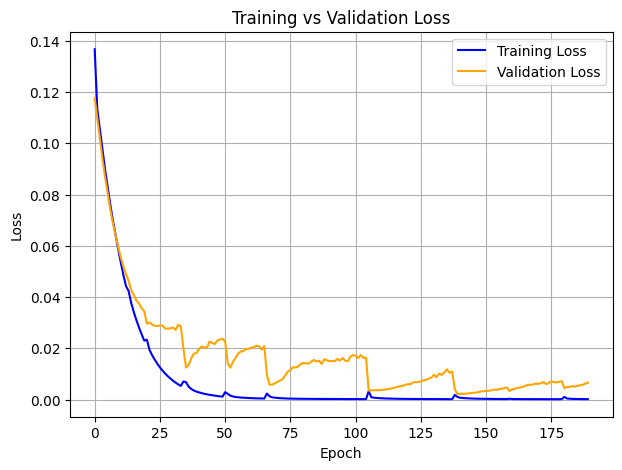

***************************
modelname:model_fold_1.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251016-FocalLoss-Experiment
Creating image arrays...
Number of label images: 12
Completed creating image arrays:
Dataset shape  (12, 256, 256, 1)
Label image shape  (12, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold1/N1-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-2.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold1/N1-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-4.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold1/N1-6.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-6.png
index =  3
予測画像: /home/eric/Documen

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13578349527987568
val_losses 0.11791529125637479
lr 0.0001
Validation loss decreased (inf --> 0.117915).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1127645193175836
val_losses 0.10915508870449331
lr 0.0001017999999999998
Validation loss decreased (0.117915 --> 0.109155).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1052335146475922
val_losses 0.10266606654557917
lr 0.00010360000000000001
Validation loss decreased (0.109155 --> 0.102666).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09857768461559759
val_losses 0.09655780875020557
lr 0.00010539999999999981
Validation loss decreased (0.102666 --> 0.096558).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09198910496903188
val_losses 0.0912518133305841
lr 0.00010720000000000002
Validation loss decreased (0.096558 --> 0.091252).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08336491370291421
val_losses 0.08599677375621266
lr 0.00010899999999999982
Validation loss decreased (0.091252 --> 0.085997).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07504134250409675
val_losses 0.08284777104854583
lr 0.00011080000000000001
Validation loss decreased (0.085997 --> 0.082848).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06978490099762426
val_losses 0.07612859735058414
lr 0.00011259999999999981
Validation loss decreased (0.082848 --> 0.076129).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.062269883625435105
val_losses 0.07389758473469152
lr 0.00011440000000000002
Validation loss decreased (0.076129 --> 0.073898).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.056093279531959334
val_losses 0.07034407849940989
lr 0.00011619999999999982
Validation loss decreased (0.073898 --> 0.070344).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05089340327364026
val_losses 0.06718590334057808
lr 0.00011800000000000002
Validation loss decreased (0.070344 --> 0.067186).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.046229043614232176
val_losses 0.0643831918016076
lr 0.00011979999999999982
Validation loss decreased (0.067186 --> 0.064383).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.042007780594356135
val_losses 0.06301426643298733
lr 0.00012160000000000003
Validation loss decreased (0.064383 --> 0.063014).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.038186601030104086
val_losses 0.06191377689441045
lr 0.00012339999999999983
Validation loss decreased (0.063014 --> 0.061914).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.034627431360158056
val_losses 0.06136694316648775
lr 0.00012520000000000003
Validation loss decreased (0.061914 --> 0.061367).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03133047473137126
val_losses 0.05786033740474118
lr 0.00012699999999999983
Validation loss decreased (0.061367 --> 0.057860).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.028429494182946102
val_losses 0.059581185918715265
lr 0.00012880000000000004
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.026237896361360043
val_losses 0.05598760675638914
lr 0.00013059999999999984
Validation loss decreased (0.057860 --> 0.055988).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.023389199652680846
val_losses 0.057946097219569816
lr 0.00013240000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020985292536065434
val_losses 0.058867694944557215
lr 0.00013419999999999985
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01893103921955282
val_losses 0.05785456975508067
lr 0.00013600000000000003
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01707163889412627
val_losses 0.059650265663448304
lr 0.00013779999999999983
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.015386224396978364
val_losses 0.05955139777312676
lr 0.00013960000000000003
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013856245769244251
val_losses 0.05882589865682854
lr 0.00014139999999999983
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.015963749398449155
val_losses 0.04444751508740915
lr 0.00014320000000000004
Validation loss decreased (0.055988 --> 0.044448).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012039677818503344
val_losses 0.04812162602837715
lr 0.00014499999999999984
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010536741984613013
val_losses 0.049195089139458206
lr 0.00014680000000000004
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009384103700744384
val_losses 0.0517165903829866
lr 0.00014859999999999984
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008392690685154362
val_losses 0.052580550183645554
lr 0.00015040000000000005
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00752528172945886
val_losses 0.05376834022916026
lr 0.00015219999999999985
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006749387573676579
val_losses 0.053978868201375006
lr 0.00015400000000000006
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006074696100514495
val_losses 0.058451633967666165
lr 0.00015579999999999986
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005447428639639508
val_losses 0.06042230599042442
lr 0.00015760000000000006
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004888904302126982
val_losses 0.061435840418562294
lr 0.00015939999999999986
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004463610975918445
val_losses 0.06114563670837217
lr 0.00016120000000000007
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003959598555935152
val_losses 0.0633985152002424
lr 0.00016299999999999984
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0035442341507102054
val_losses 0.06321483209936155
lr 0.00016480000000000005
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006210340943300363
val_losses 0.033070084421585
lr 0.00016659999999999988
Validation loss decreased (0.044448 --> 0.033070).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003960257138577149
val_losses 0.044627954161518976
lr 0.00016840000000000008
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003110141960452452
val_losses 0.04996599607531809
lr 0.00017019999999999985
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0026643386724489655
val_losses 0.054170787810451454
lr 0.00017200000000000006
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002341645343977055
val_losses 0.056587425883238514
lr 0.0001737999999999999
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002089498442894017
val_losses 0.05823269759615262
lr 0.00017560000000000007
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018798024312480155
val_losses 0.060045826670506765
lr 0.00017739999999999987
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00169096958971667
val_losses 0.06153565552344339
lr 0.00017920000000000007
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001530108951511934
val_losses 0.06190208657127288
lr 0.00018099999999999987
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001393585158582551
val_losses 0.06197325479394446
lr 0.00018280000000000008
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001266241362177287
val_losses 0.06393574209780328
lr 0.00018459999999999988
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001160196552695142
val_losses 0.06505953545371691
lr 0.00018640000000000009
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00106228734913395
val_losses 0.06555282863167425
lr 0.00018819999999999989
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009697257013723367
val_losses 0.06832433293004417
lr 0.00019000000000000006
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008902903949616082
val_losses 0.06844663330509017
lr 0.0001917999999999999
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0033088147836017674
val_losses 0.03325870938004098
lr 0.0001936000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002102876449652919
val_losses 0.03975455334487681
lr 0.00019539999999999987
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013482241210471275
val_losses 0.041754564058889325
lr 0.00019720000000000008
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010800181325369826
val_losses 0.04621104168731512
lr 0.0001989999999999999
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009094112515661188
val_losses 0.050036231145107496
lr 0.0002008000000000001
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007880797821351073
val_losses 0.052235808654222636
lr 0.00020259999999999988
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006981186921510733
val_losses 0.05574234842917779
lr 0.0002044000000000001
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006308854559337664
val_losses 0.05617666701113598
lr 0.00020619999999999992
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005743762106056127
val_losses 0.05813181720570558
lr 0.0002080000000000001
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005285338952848123
val_losses 0.059065378149453965
lr 0.0002097999999999999
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004948416647190849
val_losses 0.05953278834802202
lr 0.0002116000000000001
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00046041649148912366
val_losses 0.06041476022089935
lr 0.0002133999999999999
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00043076488946098835
val_losses 0.060485071836349866
lr 0.0002152000000000001
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00040748041770491525
val_losses 0.060309508458400767
lr 0.0002169999999999999
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003917787829061236
val_losses 0.060411911506930156
lr 0.00021880000000000011
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003690093453218596
val_losses 0.061157010736254354
lr 0.00022059999999999991
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003575765166191779
val_losses 0.059691089091615544
lr 0.0002224000000000001
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003390958836076386
val_losses 0.06044535993391441
lr 0.00022419999999999992
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00032028292568583947
val_losses 0.0629952172179603
lr 0.00022600000000000013
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00031428156609322424
val_losses 0.06072874082148903
lr 0.0002277999999999999
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00030431445074183017
val_losses 0.06027941002200047
lr 0.0002296000000000001
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00029193691593580736
val_losses 0.061530804028734565
lr 0.00023139999999999993
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002840047500671283
val_losses 0.06145657816022221
lr 0.00023320000000000014
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00027809007526340075
val_losses 0.06186009620885468
lr 0.0002349999999999999
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00032396305019078266
val_losses 0.05800183461720331
lr 0.00023680000000000012
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002609061524377797
val_losses 0.060674965516146685
lr 0.00023859999999999994
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024757778252630186
val_losses 0.06161089951896833
lr 0.00024040000000000015
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002408752334304154
val_losses 0.06044427313738399
lr 0.00024219999999999992
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00023341159539995714
val_losses 0.06123737004171643
lr 0.00024400000000000013
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002370880240712061
val_losses 0.06449026256644477
lr 0.00024579999999999996
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003383225390324228
val_losses 0.01876416394144245
lr 0.0002476000000000001
Validation loss decreased (0.033070 --> 0.018764).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008774361357967737
val_losses 0.01981927217437058
lr 0.00024939999999999994
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007109748737561996
val_losses 0.021406666779269775
lr 0.00025120000000000014
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006068078555858157
val_losses 0.02440845390277294
lr 0.0002529999999999999
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005270961422480248
val_losses 0.026717302285962634
lr 0.0002548000000000001
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00046309706142920096
val_losses 0.029131393228372972
lr 0.00025659999999999995
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004128196870266093
val_losses 0.03153299822847152
lr 0.00025840000000000016
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003714677726913413
val_losses 0.033338530427621055
lr 0.00026019999999999993
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00034051283763608697
val_losses 0.035216325988423905
lr 0.00026200000000000013
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00031382130471298075
val_losses 0.037378036624027625
lr 0.00026379999999999996
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002946684911325009
val_losses 0.0381203223627785
lr 0.00026560000000000017
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00027744783018892065
val_losses 0.040693321402391625
lr 0.00026739999999999994
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00026538288904262255
val_losses 0.042754307669949615
lr 0.00026920000000000015
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002546424702317877
val_losses 0.043193390977103265
lr 0.000271
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002487169030108348
val_losses 0.04497179089683211
lr 0.0002728000000000002
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002410182494327962
val_losses 0.04697950022915999
lr 0.00027459999999999995
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00023301898521215964
val_losses 0.04772362117267524
lr 0.00027640000000000016
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022737134449099275
val_losses 0.04739217011827147
lr 0.00027819999999999993
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022970426212079033
val_losses 0.04792560626649194
lr 0.00028000000000000014
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00023030839074635878
val_losses 0.04777115394438927
lr 0.00028179999999999997
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021687074984198042
val_losses 0.04829189190641046
lr 0.00028360000000000017
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002135564280747944
val_losses 0.04821529163746163
lr 0.00028539999999999994
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020723769588530008
val_losses 0.050972781567058215
lr 0.00028720000000000015
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020679699060344842
val_losses 0.047994262271095066
lr 0.000289
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020294893809918765
val_losses 0.052022868310773955
lr 0.0002908000000000002
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020194409188468743
val_losses 0.05250429730836509
lr 0.00029259999999999996
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019614692070965908
val_losses 0.052120867541008115
lr 0.00029440000000000016
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000189854167437068
val_losses 0.05077996876271856
lr 0.0002962
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019836871056626973
val_losses 0.04833761171127359
lr 0.0002980000000000002
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001874017278720258
val_losses 0.05052189082165973
lr 0.00029979999999999997
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018193264730860282
val_losses 0.04897305979522773
lr 0.0003016000000000002
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018975429058738164
val_losses 0.04717610573473697
lr 0.0003034
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017333383977088625
val_losses 0.053559017868246885
lr 0.00030520000000000015
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016602092661990108
val_losses 0.05109580125168173
lr 0.000307
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016657535743433983
val_losses 0.049094829841568655
lr 0.0003088000000000002
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001639208683407174
val_losses 0.05419097798747114
lr 0.00031059999999999996
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0021315908386234446
val_losses 0.01158680541945311
lr 0.0003123999999999998
Validation loss decreased (0.018764 --> 0.011587).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007981637543928104
val_losses 0.012512920918460521
lr 0.0003142
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006095404996868279
val_losses 0.01394603906373959
lr 0.0003160000000000002
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005105561842245869
val_losses 0.015456746652812905
lr 0.00031779999999999997
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004378574148921127
val_losses 0.016892409731129494
lr 0.0003195999999999998
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00038512596229063064
val_losses 0.018507162719551058
lr 0.0003214
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003451679523674433
val_losses 0.019511983867010307
lr 0.0003232000000000002
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00031416283044646576
val_losses 0.021160788770066573
lr 0.000325
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002896776862502465
val_losses 0.022263846146718908
lr 0.0003267999999999998
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00027122248425395367
val_losses 0.023704146139789373
lr 0.0003286
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002558970069389254
val_losses 0.024792662010683367
lr 0.0003304000000000002
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024225254654249346
val_losses 0.025558841760761827
lr 0.0003322
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00023248764852972024
val_losses 0.02686924444149352
lr 0.0003339999999999998
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022496249214534395
val_losses 0.028906562009878043
lr 0.00033580000000000003
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021487686798068214
val_losses 0.02931863514176156
lr 0.0003376000000000002
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020833784739917257
val_losses 0.029660971775107705
lr 0.0003394
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020124641362627066
val_losses 0.03075913761406102
lr 0.00034119999999999984
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019877027313641244
val_losses 0.03068550496763136
lr 0.000343
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019107535776900918
val_losses 0.031140300691024296
lr 0.0003448000000000002
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018937665224780866
val_losses 0.032590093481768334
lr 0.0003466
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000183713362882069
val_losses 0.033611059818779015
lr 0.0003483999999999998
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017893862708605768
val_losses 0.03481824336599352
lr 0.0003502
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018177985528547487
val_losses 0.0374903798271488
lr 0.0003520000000000002
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017640973700591448
val_losses 0.03578587844838492
lr 0.00035380000000000003
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016812414105515927
val_losses 0.035285463352273734
lr 0.0003555999999999998
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016932313601225333
val_losses 0.03751753595812867
lr 0.0003574
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016567562914023064
val_losses 0.03750397397412194
lr 0.00035919999999999984
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001589683979876678
val_losses 0.038244863414567794
lr 0.000361
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015626752351774044
val_losses 0.0378393825635107
lr 0.0003627999999999998
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001515813442396889
val_losses 0.04359490878414363
lr 0.0003646
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015504368897051212
val_losses 0.040775625622417364
lr 0.0003663999999999998
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001886061506935
val_losses 0.04059290357529082
lr 0.0003682
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006713342843189215
val_losses 0.02290303194248635
lr 0.00036999999999999983
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00028690062141377534
val_losses 0.025887647399859916
lr 0.00037180000000000004
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022760286334563384
val_losses 0.027928418571698584
lr 0.0003735999999999998
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019911684617964607
val_losses 0.029476860400366907
lr 0.0003754
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018109119709785746
val_losses 0.030954630613430508
lr 0.00037719999999999984
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001671476106187611
val_losses 0.031953850189327365
lr 0.00037900000000000005
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001574081989405606
val_losses 0.03416196197892229
lr 0.0003807999999999998
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015026464746121994
val_losses 0.034914657057055994
lr 0.00038260000000000003
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014441213242014672
val_losses 0.0351359495621485
lr 0.00038439999999999986
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014050750350262124
val_losses 0.03618245867805348
lr 0.00038620000000000006
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001389500895157019
val_losses 0.03570282602061828
lr 0.00038799999999999984
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001376084857011764
val_losses 0.037420689590120064
lr 0.00038980000000000004
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001388150361228988
val_losses 0.036439069844264954
lr 0.00039159999999999987
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00013257034255674982
val_losses 0.036646459869936934
lr 0.0003934
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00013131824556639361
val_losses 0.03809734938743835
lr 0.00039519999999999985
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00012818915645105086
val_losses 0.037832971098315384
lr 0.00039700000000000005
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001257106333055576
val_losses 0.038796941399212095
lr 0.00039879999999999983
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00012408933993852275
val_losses 0.03870167464224829
lr 0.00040060000000000003
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00012123345150030218
val_losses 0.03845423013101228
lr 0.00040239999999999986
EarlyStopping counter: 50 out of 50
early stopping epoch: 168


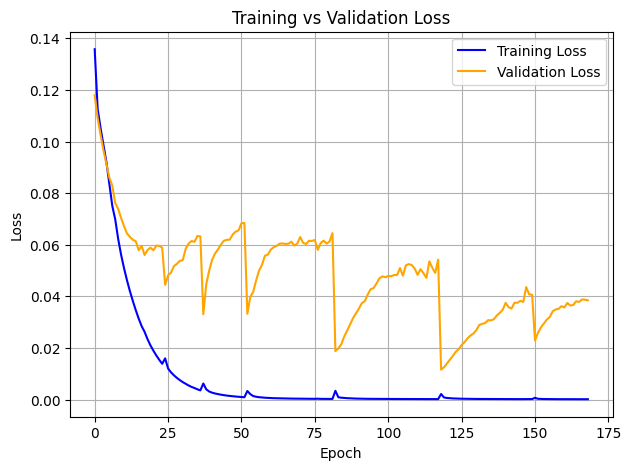

***************************
modelname:model_fold_2.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251016-FocalLoss-Experiment
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold2/N1-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-3.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold2/N1-8.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-8.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold2/N1-9.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-9.png
index =  3
予測画像: /home/eric/Documen

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13639817669084578
val_losses 0.11749239679839876
lr 0.0001
Validation loss decreased (inf --> 0.117492).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.11301775825294581
val_losses 0.10906921335392528
lr 0.0001017999999999998
Validation loss decreased (0.117492 --> 0.109069).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.105344823341478
val_losses 0.10234480976230569
lr 0.00010360000000000001
Validation loss decreased (0.109069 --> 0.102345).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09829848546421889
val_losses 0.09538627622856034
lr 0.00010539999999999981
Validation loss decreased (0.102345 --> 0.095386).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0905554992683006
val_losses 0.08741534426808358
lr 0.00010720000000000002
Validation loss decreased (0.095386 --> 0.087415).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08102571614312404
val_losses 0.08154763885670238
lr 0.00010899999999999982
Validation loss decreased (0.087415 --> 0.081548).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07271714494986968
val_losses 0.07616828307509423
lr 0.00011080000000000001
Validation loss decreased (0.081548 --> 0.076168).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06581530335048834
val_losses 0.07142602304617564
lr 0.00011259999999999981
Validation loss decreased (0.076168 --> 0.071426).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06059696162966165
val_losses 0.07674366359909375
lr 0.00011440000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05568214176279126
val_losses 0.0627759788185358
lr 0.00011619999999999982
Validation loss decreased (0.071426 --> 0.062776).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05037437222446456
val_losses 0.06023356037007438
lr 0.00011800000000000002
Validation loss decreased (0.062776 --> 0.060234).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04588168433895617
val_losses 0.05791309422088994
lr 0.00011979999999999982
Validation loss decreased (0.060234 --> 0.057913).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04182177070866932
val_losses 0.05874984848002593
lr 0.00012160000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03834881148103512
val_losses 0.05116701270971033
lr 0.00012339999999999983
Validation loss decreased (0.057913 --> 0.051167).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.034592155869485754
val_losses 0.051638253384994136
lr 0.00012520000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03129862870343707
val_losses 0.05017981386433045
lr 0.00012699999999999983
Validation loss decreased (0.051167 --> 0.050180).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.028321163536924304
val_losses 0.048323013819754124
lr 0.00012880000000000004
Validation loss decreased (0.050180 --> 0.048323).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02568886037351507
val_losses 0.04673481184161372
lr 0.00013059999999999984
Validation loss decreased (0.048323 --> 0.046735).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.023167606217391563
val_losses 0.04798665240200029
lr 0.00013240000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020917811301169972
val_losses 0.04563339857591523
lr 0.00013419999999999985
Validation loss decreased (0.046735 --> 0.045633).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.018866344631621332
val_losses 0.04375391731866532
lr 0.00013600000000000003
Validation loss decreased (0.045633 --> 0.043754).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.017945464548062194
val_losses 0.05126305957221323
lr 0.00013779999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01842017921929558
val_losses 0.03329281004973584
lr 0.00013960000000000003
Validation loss decreased (0.043754 --> 0.033293).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.014637166315294577
val_losses 0.0366706566988594
lr 0.00014139999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012936730922736001
val_losses 0.03848919625807967
lr 0.00014320000000000004
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011552549320075548
val_losses 0.03871576885382334
lr 0.00014499999999999984
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010358705055533034
val_losses 0.03813898825190133
lr 0.00014680000000000004
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009290334943569067
val_losses 0.03911477602604363
lr 0.00014859999999999984
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008342328770650607
val_losses 0.038851057458668944
lr 0.00015040000000000005
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0074800603543267105
val_losses 0.03991259964596894
lr 0.00015219999999999985
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0067285330712117935
val_losses 0.03783630357227392
lr 0.00015400000000000006
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006037922216240655
val_losses 0.04163024784065783
lr 0.00015579999999999986
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0054503968140731255
val_losses 0.04004606832750142
lr 0.00015760000000000006
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004874709460912554
val_losses 0.039564624030349986
lr 0.00015939999999999986
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004358570178208703
val_losses 0.04043370375099282
lr 0.00016120000000000007
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00391113612673838
val_losses 0.042685463491620286
lr 0.00016299999999999984
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0035285403429897444
val_losses 0.04222913176442186
lr 0.00016480000000000005
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003161571382996485
val_losses 0.043601154091043606
lr 0.00016659999999999988
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002819719926143686
val_losses 0.04647086288573014
lr 0.00016840000000000008
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0033865329738932124
val_losses 0.06075928786562549
lr 0.00017019999999999985
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006205420360448912
val_losses 0.02538278963183984
lr 0.00017200000000000006
Validation loss decreased (0.033293 --> 0.025383).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002985727744684978
val_losses 0.029082579949560265
lr 0.0001737999999999999
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002389876785772768
val_losses 0.03256623192897273
lr 0.00017560000000000007
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002039982511831278
val_losses 0.03451266954652965
lr 0.00017739999999999987
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001789732580073178
val_losses 0.03684027326655471
lr 0.00017920000000000007
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001593724018047479
val_losses 0.03995964363631275
lr 0.00018099999999999987
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001430608778063095
val_losses 0.04282601591613558
lr 0.00018280000000000008
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001289230376961782
val_losses 0.04257862518231074
lr 0.00018459999999999988
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0011705054160715503
val_losses 0.04427882646365712
lr 0.00018640000000000009
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010680617787522462
val_losses 0.04559062798507511
lr 0.00018819999999999989
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009776287292356067
val_losses 0.04249971471726895
lr 0.00019000000000000006
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008982102312570946
val_losses 0.04543086324249291
lr 0.0001917999999999999
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009379381582028035
val_losses 0.03822548730402357
lr 0.0001936000000000001
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003867091853736025
val_losses 0.01378568036145427
lr 0.00019539999999999987
Validation loss decreased (0.025383 --> 0.013786).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014841577376831661
val_losses 0.017086597393629038
lr 0.00019720000000000008
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0011217346418451405
val_losses 0.0198957516410802
lr 0.0001989999999999999
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009270102716982364
val_losses 0.0221584888938297
lr 0.0002008000000000001
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007963947140414155
val_losses 0.024080599383968445
lr 0.00020259999999999988
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000703835051866587
val_losses 0.0260274646557971
lr 0.0002044000000000001
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006330221020052153
val_losses 0.02757171236185564
lr 0.00020619999999999992
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005745747952129353
val_losses 0.0297129113951491
lr 0.0002080000000000001
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005283254646752594
val_losses 0.029837294339409307
lr 0.0002097999999999999
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004931872854340878
val_losses 0.03062491751689878
lr 0.0002116000000000001
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004568611507155848
val_losses 0.03294513580751502
lr 0.0002133999999999999
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004302328997503289
val_losses 0.033302049822587936
lr 0.0002152000000000001
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004121832934977261
val_losses 0.03284445315754662
lr 0.0002169999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00038417028624804293
val_losses 0.03417913487388028
lr 0.00021880000000000011
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00036605435950949676
val_losses 0.035331613624778886
lr 0.00022059999999999991
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003476777793945406
val_losses 0.03496481132590108
lr 0.0002224000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003310445484451272
val_losses 0.03599586557183001
lr 0.00022419999999999992
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003186483790738169
val_losses 0.034713424594762426
lr 0.00022600000000000013
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00030608384748285805
val_losses 0.03414939156888674
lr 0.0002277999999999999
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00035311564632028227
val_losses 0.03548933698459425
lr 0.0002296000000000001
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0028243668911851604
val_losses 0.011672869726963755
lr 0.00023139999999999993
Validation loss decreased (0.013786 --> 0.011673).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009500030458156922
val_losses 0.01182347074273922
lr 0.00023320000000000014
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007524689095038356
val_losses 0.012276014364841912
lr 0.0002349999999999999
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006322778766678477
val_losses 0.012765542323015527
lr 0.00023680000000000012
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005467588702837626
val_losses 0.012760495864656857
lr 0.00023859999999999994
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00048465390352772154
val_losses 0.013283381539966083
lr 0.00024040000000000015
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004364852853486258
val_losses 0.013611979197917713
lr 0.00024219999999999992
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00039913120298561724
val_losses 0.01447648042295542
lr 0.00024400000000000013
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003696456376928836
val_losses 0.01459363181816621
lr 0.00024579999999999996
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00034493008905414944
val_losses 0.015550967651264121
lr 0.0002476000000000001
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003266022501823803
val_losses 0.015784778722122104
lr 0.00024939999999999994
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00031207189418968153
val_losses 0.017158668908652745
lr 0.00025120000000000014
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00030237322454481865
val_losses 0.016141585732758458
lr 0.0002529999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002831827323516887
val_losses 0.017637692525750027
lr 0.0002548000000000001
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000277894144749029
val_losses 0.01852405874265565
lr 0.00025659999999999995
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00026370369481755365
val_losses 0.019199063919950278
lr 0.00025840000000000016
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002561592346120795
val_losses 0.01828102459354947
lr 0.00026019999999999993
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024701171020172875
val_losses 0.01891330053978082
lr 0.00026200000000000013
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002426501997185617
val_losses 0.01753562903031707
lr 0.00026379999999999996
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002376474678661025
val_losses 0.01953041860057662
lr 0.00026560000000000017
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00023037599466712864
val_losses 0.01919952588699137
lr 0.00026739999999999994
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024273678568671598
val_losses 0.01656275423657563
lr 0.00026920000000000015
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022128173379425072
val_losses 0.018876118428953405
lr 0.000271
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002169013629265299
val_losses 0.019082942301045274
lr 0.0002728000000000002
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021470563771083218
val_losses 0.017946040379400882
lr 0.00027459999999999995
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020820437321989713
val_losses 0.017484355371238457
lr 0.00027640000000000016
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020972683097087694
val_losses 0.01781978431649299
lr 0.00027819999999999993
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003695729284751878
val_losses 0.013276282364192109
lr 0.00028000000000000014
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018904719894194523
val_losses 0.00524066086670953
lr 0.00028179999999999997
Validation loss decreased (0.011673 --> 0.005241).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000623845462211069
val_losses 0.005401713666570787
lr 0.00028360000000000017
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004995593236702861
val_losses 0.005782099818720275
lr 0.00028539999999999994
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004248380893841386
val_losses 0.006448593624453578
lr 0.00028720000000000015
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003736764819636433
val_losses 0.006496103200414736
lr 0.000289
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00033681455198816503
val_losses 0.006682582751252792
lr 0.0002908000000000002
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003088490278142589
val_losses 0.007080746969829003
lr 0.00029259999999999996
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000288492615623964
val_losses 0.007218959539507826
lr 0.00029440000000000016
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002712872418201049
val_losses 0.0077347665223189525
lr 0.0002962
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00025762634940099707
val_losses 0.008127342648933538
lr 0.0002980000000000002
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024536671615240984
val_losses 0.00824527366203256
lr 0.00029979999999999997
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00023634469910052068
val_losses 0.008840208663605154
lr 0.0003016000000000002
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022913145556671997
val_losses 0.008967151117071302
lr 0.0003034
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022275302996576735
val_losses 0.00948780005823614
lr 0.00030520000000000015
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021668503860851297
val_losses 0.01025870918141057
lr 0.000307
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021115008963864634
val_losses 0.01043869463998514
lr 0.0003088000000000002
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020619056868423341
val_losses 0.010007583321486083
lr 0.00031059999999999996
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020148419386135753
val_losses 0.01063476126615165
lr 0.0003123999999999998
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020153010581535372
val_losses 0.011405169578372605
lr 0.0003142
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001968456221441033
val_losses 0.010927587438426497
lr 0.0003160000000000002
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019204246394413833
val_losses 0.011743072738560538
lr 0.00031779999999999997
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019073295142416928
val_losses 0.012213506986800996
lr 0.0003195999999999998
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018474833257531634
val_losses 0.011972438262051178
lr 0.0003214
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018203447623157197
val_losses 0.011692603907754852
lr 0.0003232000000000002
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001790563584522302
val_losses 0.013953923203775451
lr 0.000325
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017660938994429836
val_losses 0.012731439776770357
lr 0.0003267999999999998
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001717956645844617
val_losses 0.013680588902853843
lr 0.0003286
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017305058252973002
val_losses 0.013301089334870793
lr 0.0003304000000000002
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016695644585662663
val_losses 0.012897099995623447
lr 0.0003322
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017897832463363143
val_losses 0.004406851430475298
lr 0.0003339999999999998
Validation loss decreased (0.005241 --> 0.004407).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000762382838663391
val_losses 0.004519457129774512
lr 0.00033580000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005746130254754627
val_losses 0.005100498861995422
lr 0.0003376000000000002
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004789535832859463
val_losses 0.005360754772037682
lr 0.0003394
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00041290273524778473
val_losses 0.005894514318141673
lr 0.00034119999999999984
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00036647637184201315
val_losses 0.006314180529443547
lr 0.000343
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003300748279081855
val_losses 0.006597832297363008
lr 0.0003448000000000002
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000302386948235587
val_losses 0.006975993267648543
lr 0.0003466
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00028012393723298427
val_losses 0.007383825068569018
lr 0.0003483999999999998
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00026330565076822303
val_losses 0.007846662910499921
lr 0.0003502
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024837709003777214
val_losses 0.007970830062145575
lr 0.0003520000000000002
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002360776320336189
val_losses 0.008208938365310638
lr 0.00035380000000000003
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022680167678503714
val_losses 0.00844244763526755
lr 0.0003555999999999998
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021689450862168362
val_losses 0.00864610282264443
lr 0.0003574
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020997097572862086
val_losses 0.008911267583931072
lr 0.00035919999999999984
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002030334958390361
val_losses 0.009000603222779723
lr 0.000361
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019613267936757908
val_losses 0.009300320151831127
lr 0.0003627999999999998
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001945653001629663
val_losses 0.009550370002398268
lr 0.0003646
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001872397329090304
val_losses 0.009774467638150479
lr 0.0003663999999999998
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018319955667142162
val_losses 0.010256749600456614
lr 0.0003682
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017847150632984598
val_losses 0.010104144076790868
lr 0.00036999999999999983
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017515765591242323
val_losses 0.01039926858049714
lr 0.00037180000000000004
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001720196922895301
val_losses 0.010430970920586131
lr 0.0003735999999999998
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016918271031692822
val_losses 0.010105372773897317
lr 0.0003754
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001728516289872597
val_losses 0.010380902350880206
lr 0.00037719999999999984
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016302172152791173
val_losses 0.010893506427398987
lr 0.00037900000000000005
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001610904357221443
val_losses 0.011045859320761842
lr 0.0003807999999999998
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015920901123811772
val_losses 0.011304791562724858
lr 0.00038260000000000003
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001557648002441662
val_losses 0.011265929972028566
lr 0.00038439999999999986
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001509313436999395
val_losses 0.011530640818333875
lr 0.00038620000000000006
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014798027965077904
val_losses 0.01134471461797754
lr 0.00038799999999999984
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014593599773819955
val_losses 0.011687777225031622
lr 0.00038980000000000004
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014158810643659142
val_losses 0.0111098952513809
lr 0.00039159999999999987
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00013955663763970898
val_losses 0.01142237577199315
lr 0.0003934
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014241626045215084
val_losses 0.01150351473932258
lr 0.00039519999999999985
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001361325705974278
val_losses 0.011747018069339294
lr 0.00039700000000000005
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00013226186058476962
val_losses 0.012629028612799529
lr 0.00039879999999999983
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001293041420109203
val_losses 0.012080894228226195
lr 0.00040060000000000003
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00012667711352784837
val_losses 0.01284001473363282
lr 0.00040239999999999986
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001225407131035657
val_losses 0.01170943802765881
lr 0.00040420000000000007
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00011875996258988214
val_losses 0.01253321383588223
lr 0.00040599999999999984
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00011580364798922374
val_losses 0.012855788819595343
lr 0.00040780000000000005
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00011468594840897077
val_losses 0.013165759537110312
lr 0.0004095999999999999
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001152564032412501
val_losses 0.01246242897791995
lr 0.0004114000000000001
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00044056562639360145
val_losses 0.00375473529598417
lr 0.00041319999999999985
Validation loss decreased (0.004407 --> 0.003755).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000256796795513241
val_losses 0.004824321263650846
lr 0.00041500000000000006
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018716116500207025
val_losses 0.005454117447758714
lr 0.0004167999999999999
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015600187195531995
val_losses 0.006080826108033458
lr 0.0004186000000000001
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001368114472963057
val_losses 0.006671063426054186
lr 0.00042039999999999986
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00012292668711090686
val_losses 0.007019604148808867
lr 0.00042220000000000007
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00011342648634154377
val_losses 0.007285143867031567
lr 0.00042399999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00010981088094977718
val_losses 0.007646171007460604
lr 0.00042580000000000005
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00010391828724426555
val_losses 0.0077630282767737905
lr 0.0004275999999999999
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00010217867368765203
val_losses 0.007722714496776461
lr 0.0004294000000000001
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00010275187417970632
val_losses 0.008189137347249522
lr 0.00043119999999999986
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.996187055190658e-05
val_losses 0.008491710488063594
lr 0.00043300000000000006
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.969043647729311e-05
val_losses 0.008727966282620198
lr 0.0004347999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.763698727703851e-05
val_losses 0.008418556476115353
lr 0.0004366000000000001
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00010140616163191611
val_losses 0.008683316890771191
lr 0.00043839999999999987
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.922301333889746e-05
val_losses 0.00856953306744496
lr 0.0004402000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.405553215456718e-05
val_losses 0.009070807350023339
lr 0.0004419999999999999
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.32438562978694e-05
val_losses 0.009356433669260393
lr 0.0004438000000000001
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.041617470784607e-05
val_losses 0.010052426423256596
lr 0.0004455999999999999
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.243611176233653e-05
val_losses 0.009262906725052745
lr 0.0004474000000000001
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 9.131152832141555e-05
val_losses 0.009953870484605432
lr 0.0004491999999999999
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 8.715639726715657e-05
val_losses 0.009783310115906513
lr 0.0004510000000000001
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 8.677166575084398e-05
val_losses 0.010380832991924965
lr 0.0004527999999999999
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 8.413652249146253e-05
val_losses 0.009934060538135883
lr 0.0004546000000000001
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 8.381247937381197e-05
val_losses 0.010501549151053445
lr 0.00045639999999999987
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 8.121987038149117e-05
val_losses 0.010585149785038083
lr 0.0004582000000000001
EarlyStopping counter: 25 out of 50


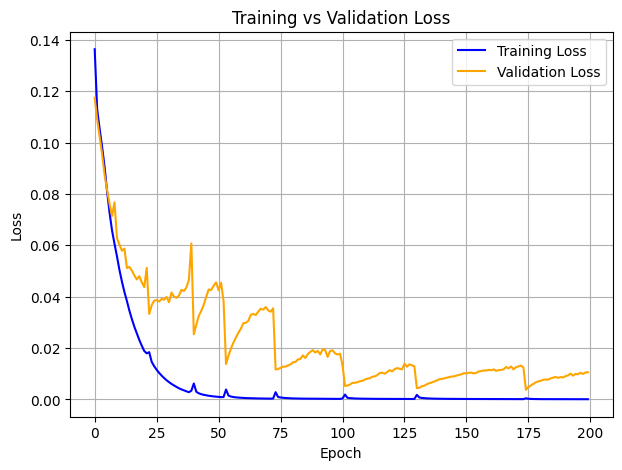

***************************
modelname:model_fold_3.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251016-FocalLoss-Experiment
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold3/N1-5.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-5.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold3/N1-10.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-10.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold3/N2-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N2-4.png
index =  3
予測画像: /home/eric/Docum

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13622801470937151
val_losses 0.11784838578767247
lr 0.0001
Validation loss decreased (inf --> 0.117848).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.11342541780887228
val_losses 0.10957638546824455
lr 0.0001017999999999998
Validation loss decreased (0.117848 --> 0.109576).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10589892794236992
val_losses 0.10253463296426667
lr 0.00010360000000000001
Validation loss decreased (0.109576 --> 0.102535).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09870683067675792
val_losses 0.09506152611639765
lr 0.00010539999999999981
Validation loss decreased (0.102535 --> 0.095062).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09097277966864181
val_losses 0.087986202372445
lr 0.00010720000000000002
Validation loss decreased (0.095062 --> 0.087986).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08344637117151057
val_losses 0.08113939174347454
lr 0.00010899999999999982
Validation loss decreased (0.087986 --> 0.081139).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07579464795011463
val_losses 0.07458222239381737
lr 0.00011080000000000001
Validation loss decreased (0.081139 --> 0.074582).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06900170982787103
val_losses 0.06977110426459047
lr 0.00011259999999999981
Validation loss decreased (0.074582 --> 0.069771).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06286882076299552
val_losses 0.06598322455667788
lr 0.00011440000000000002
Validation loss decreased (0.069771 --> 0.065983).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05856405844291051
val_losses 0.06128160059452057
lr 0.00011619999999999982
Validation loss decreased (0.065983 --> 0.061282).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05245143886316906
val_losses 0.05806097601436906
lr 0.00011800000000000002
Validation loss decreased (0.061282 --> 0.058061).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04772842919284647
val_losses 0.05483950285447969
lr 0.00011979999999999982
Validation loss decreased (0.058061 --> 0.054840).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04361091579000155
val_losses 0.05279965988463826
lr 0.00012160000000000003
Validation loss decreased (0.054840 --> 0.052800).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03980856062562177
val_losses 0.04987832653439707
lr 0.00012339999999999983
Validation loss decreased (0.052800 --> 0.049878).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.036395786183350015
val_losses 0.04804397159152561
lr 0.00012520000000000003
Validation loss decreased (0.049878 --> 0.048044).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.033283787824665054
val_losses 0.045018559259672956
lr 0.00012699999999999983
Validation loss decreased (0.048044 --> 0.045019).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.030330833188737884
val_losses 0.04272827263921499
lr 0.00012880000000000004
Validation loss decreased (0.045019 --> 0.042728).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02759859874618776
val_losses 0.042650208394560546
lr 0.00013059999999999984
Validation loss decreased (0.042728 --> 0.042650).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.025160979727904
val_losses 0.04249277224557267
lr 0.00013240000000000002
Validation loss decreased (0.042650 --> 0.042493).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022755313980759997
val_losses 0.040143160584072274
lr 0.00013419999999999985
Validation loss decreased (0.042493 --> 0.040143).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020792668922380967
val_losses 0.038570284108734795
lr 0.00013600000000000003
Validation loss decreased (0.040143 --> 0.038570).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.018657033201871495
val_losses 0.036687409567336245
lr 0.00013779999999999983
Validation loss decreased (0.038570 --> 0.036687).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016807485213785462
val_losses 0.0373828273680475
lr 0.00013960000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01519095017998056
val_losses 0.034958142559561464
lr 0.00014139999999999983
Validation loss decreased (0.036687 --> 0.034958).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01370736395827297
val_losses 0.03562815080707272
lr 0.00014320000000000004
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012344528232334237
val_losses 0.035419696372830205
lr 0.00014499999999999984
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011109169866099501
val_losses 0.03444143800685803
lr 0.00014680000000000004
Validation loss decreased (0.034958 --> 0.034441).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01000188078844186
val_losses 0.0346920693707135
lr 0.00014859999999999984
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0089973976962607
val_losses 0.032260122113964625
lr 0.00015040000000000005
Validation loss decreased (0.034441 --> 0.032260).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012660407959342455
val_losses 0.018198323937960798
lr 0.00015219999999999985
Validation loss decreased (0.032260 --> 0.018198).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010272972488945181
val_losses 0.020962711314981182
lr 0.00015400000000000006
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008081481875287313
val_losses 0.022281110824810133
lr 0.00015579999999999986
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0069114643233743585
val_losses 0.023687735293060543
lr 0.00015760000000000006
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00596033573630407
val_losses 0.02471550114245878
lr 0.00015939999999999986
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005239908474807938
val_losses 0.02607122203335166
lr 0.00016120000000000007
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004672486888188304
val_losses 0.026351220973042978
lr 0.00016299999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004173243467018686
val_losses 0.027377449731445975
lr 0.00016480000000000005
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003753399085535696
val_losses 0.026832999682260883
lr 0.00016659999999999988
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0033642666188604905
val_losses 0.02736033809164332
lr 0.00016840000000000008
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0030230943480450095
val_losses 0.026909464742574427
lr 0.00017019999999999985
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0027291254972982588
val_losses 0.028072007704112265
lr 0.00017200000000000006
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024601812417985817
val_losses 0.028688335690336922
lr 0.0001737999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002218984456196653
val_losses 0.029236414066205422
lr 0.00017560000000000007
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0020016415785490114
val_losses 0.029516319012165896
lr 0.00017739999999999987
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017943721014131424
val_losses 0.030409494197616974
lr 0.00017920000000000007
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016375184538915302
val_losses 0.02874555720999423
lr 0.00018099999999999987
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014930494034408846
val_losses 0.029528336529619992
lr 0.00018280000000000008
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014328953778286549
val_losses 0.03789007719864862
lr 0.00018459999999999988
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006393113614158761
val_losses 0.006455969210300181
lr 0.00018640000000000009
Validation loss decreased (0.018198 --> 0.006456).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0025193731050063488
val_losses 0.012230399685601393
lr 0.00018819999999999989
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017733247887173837
val_losses 0.014981361619559014
lr 0.00019000000000000006
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001426011530301449
val_losses 0.018074102203051248
lr 0.0001917999999999999
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001213174197597034
val_losses 0.020499057930687237
lr 0.0001936000000000001
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010619643100212809
val_losses 0.02101328439053355
lr 0.00019539999999999987
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009458143772049384
val_losses 0.02175696599814627
lr 0.00019720000000000008
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000850117712098202
val_losses 0.023355099080233938
lr 0.0001989999999999999
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007808523164412966
val_losses 0.024350599616041614
lr 0.0002008000000000001
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000738059534077448
val_losses 0.02466909765886764
lr 0.00020259999999999988
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006641108228712145
val_losses 0.024241705471649767
lr 0.0002044000000000001
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006032308447174728
val_losses 0.02611034790623105
lr 0.00020619999999999992
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005628604701169852
val_losses 0.026523666590866114
lr 0.0002080000000000001
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005291193513778236
val_losses 0.02652155330352899
lr 0.0002097999999999999
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004985294758984254
val_losses 0.02540002857438392
lr 0.0002116000000000001
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004733305020525939
val_losses 0.02664367167227384
lr 0.0002133999999999999
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004944578036277865
val_losses 0.023258108102406066
lr 0.0002152000000000001
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00041748034894805065
val_losses 0.023951789177954198
lr 0.0002169999999999999
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003903298557623092
val_losses 0.02591113785488738
lr 0.00021880000000000011
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00039868672884591487
val_losses 0.023847270019662876
lr 0.00022059999999999991
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003713459265065577
val_losses 0.02604281315062609
lr 0.0002224000000000001
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00033645114224672203
val_losses 0.026262393671398362
lr 0.00022419999999999992
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00047329244897065855
val_losses 0.021895621869609586
lr 0.00022600000000000013
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004152806589704458
val_losses 0.003513108083926555
lr 0.0002277999999999999
Validation loss decreased (0.006456 --> 0.003513).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012894678236493333
val_losses 0.003688008155182211
lr 0.0002296000000000001
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009987967963697333
val_losses 0.0038833648858902356
lr 0.00023139999999999993
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008338577715524783
val_losses 0.004161286642516239
lr 0.00023320000000000014
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007156692856259532
val_losses 0.0045488200719571775
lr 0.0002349999999999999
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006301533250900155
val_losses 0.004969495200526176
lr 0.00023680000000000012
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005656418685138113
val_losses 0.005242638282814167
lr 0.00023859999999999994
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005108893847191763
val_losses 0.005748888419475406
lr 0.00024040000000000015
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00046553108567781184
val_losses 0.006268672301666811
lr 0.00024219999999999992
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0004283308534826519
val_losses 0.0065700082011365644
lr 0.00024400000000000013
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00039723159015094017
val_losses 0.0068043789891008705
lr 0.00024579999999999996
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003786454904140114
val_losses 0.007071448883895452
lr 0.0002476000000000001
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00034907852161929686
val_losses 0.00792619881556473
lr 0.00024939999999999994
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003315155634261442
val_losses 0.0076786343823187055
lr 0.00025120000000000014
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003166953815239002
val_losses 0.008201414031080073
lr 0.0002529999999999999
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003044489816988282
val_losses 0.00834534672063051
lr 0.0002548000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003402668655105641
val_losses 0.007610172804238068
lr 0.00025659999999999995
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002929640761453122
val_losses 0.007879980504771487
lr 0.00025840000000000016
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00027772962348535655
val_losses 0.009025271826734146
lr 0.00026019999999999993
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000267254084853145
val_losses 0.009062837187149045
lr 0.00026200000000000013
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002635441175891284
val_losses 0.009046623059031035
lr 0.00026379999999999996
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000266553217608651
val_losses 0.008732752856384548
lr 0.00026560000000000017
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002451822596027121
val_losses 0.00941801214357838
lr 0.00026739999999999994
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024191352867725954
val_losses 0.009958526427443657
lr 0.00026920000000000015
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024149099710594975
val_losses 0.009792250520291014
lr 0.000271
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018452155818742925
val_losses 0.004197887325426563
lr 0.0002728000000000002
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0011559864204503934
val_losses 0.002275078800933746
lr 0.00027459999999999995
Validation loss decreased (0.003513 --> 0.002275).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007692458205080281
val_losses 0.002381917557472156
lr 0.00027640000000000016
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006408716834178477
val_losses 0.002576043412166958
lr 0.00027819999999999993
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005533546219918538
val_losses 0.002710185134977413
lr 0.00028000000000000014
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000485719839520188
val_losses 0.0028994086864663083
lr 0.00028179999999999997
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00043253419994884594
val_losses 0.0031188707869862103
lr 0.00028360000000000017
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003914786978963424
val_losses 0.0031973065135793553
lr 0.00028539999999999994
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003591472126903351
val_losses 0.0034376710278189015
lr 0.00028720000000000015
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0003331216443753378
val_losses 0.0035629771177708687
lr 0.000289
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00031826498858263775
val_losses 0.0036752922078853267
lr 0.0002908000000000002
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00029995809216581455
val_losses 0.004008153573118357
lr 0.00029259999999999996
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002856081319888207
val_losses 0.004027622370308058
lr 0.00029440000000000016
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002736654424524838
val_losses 0.004212870051722146
lr 0.0002962
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002728690855843579
val_losses 0.004339379794611078
lr 0.0002980000000000002
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002598522831139042
val_losses 0.004652185172178886
lr 0.00029979999999999997
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024956342606332547
val_losses 0.004761131766847232
lr 0.0003016000000000002
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002458824077621102
val_losses 0.004815190605586395
lr 0.0003034
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00024099326397073595
val_losses 0.004800993837286821
lr 0.00030520000000000015
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002332622510342238
val_losses 0.004862873417247708
lr 0.000307
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022925844580944007
val_losses 0.0051298806398537835
lr 0.0003088000000000002
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022573837896660816
val_losses 0.0050591567990421835
lr 0.00031059999999999996
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00022345974606595876
val_losses 0.005437263438943773
lr 0.0003123999999999998
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021497523936859304
val_losses 0.005398707717217298
lr 0.0003142
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00020985014989767506
val_losses 0.005714962910860777
lr 0.0003160000000000002
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00021691839634017512
val_losses 0.0053436740320951985
lr 0.00031779999999999997
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002059837842490665
val_losses 0.006140848982613534
lr 0.0003195999999999998
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019593651077505484
val_losses 0.00636050860500998
lr 0.0003214
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001979091978600164
val_losses 0.005969467549584806
lr 0.0003232000000000002
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00019407581333353213
val_losses 0.006190461375647121
lr 0.000325
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018814620936719812
val_losses 0.006247838185582724
lr 0.0003267999999999998
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018213274134640497
val_losses 0.0062212641156899435
lr 0.0003286
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018505496396259828
val_losses 0.006437021403366493
lr 0.0003304000000000002
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018142459558668743
val_losses 0.00670798106584698
lr 0.0003322
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005665566677855553
val_losses 0.003675723723265239
lr 0.0003339999999999998
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002492157733120786
val_losses 0.004277809554090102
lr 0.00033580000000000003
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0002075964160736255
val_losses 0.004734716376858867
lr 0.0003376000000000002
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00018827723062272663
val_losses 0.005100881054143732
lr 0.0003394
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00017557767745474297
val_losses 0.005431086739473459
lr 0.00034119999999999984
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016720068548844818
val_losses 0.005788422582878007
lr 0.000343
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.000163477347814478
val_losses 0.005729467739971975
lr 0.0003448000000000002
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00016109399975076404
val_losses 0.006001424180188526
lr 0.0003466
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015942136810873775
val_losses 0.005945165870555987
lr 0.0003483999999999998
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015544580969479725
val_losses 0.0062579613942135535
lr 0.0003502
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015376742658466383
val_losses 0.0065015732155491906
lr 0.0003520000000000002
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00015114198992677937
val_losses 0.00665943903150037
lr 0.00035380000000000003
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001545598744114889
val_losses 0.006663079123892304
lr 0.0003555999999999998
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001472205933444484
val_losses 0.006852250303038292
lr 0.0003574
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014478747453364177
val_losses 0.007125643969306515
lr 0.00035919999999999984
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00014684043690618693
val_losses 0.00679130646167323
lr 0.000361
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001424993142074637
val_losses 0.0068544545909389855
lr 0.0003627999999999998
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0001354277861978379
val_losses 0.0073353430941804415
lr 0.0003646
EarlyStopping counter: 50 out of 50
early stopping epoch: 147


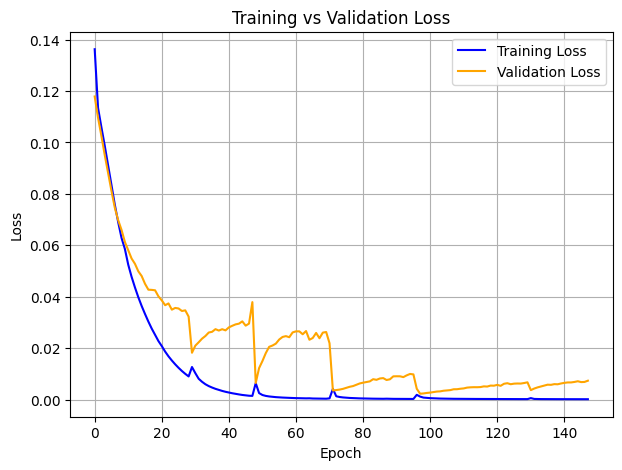

***************************
modelname:model_fold_4.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251016-FocalLoss-Experiment
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold4/N1-1.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-1.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold4/N1-7.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-7.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251016-FocalLoss-Experiment/fold4/N2-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N2-3.png
index =  3
予測画像: /home/eric/Documen

In [20]:
## Execution
from dataArrange import dataRearrange1
## Test Learn_EA without annealing
# training transformations and augmentations

transforms_training = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

#追加箇所ver3
transforms_val =  ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)

])

# random seed
random_seed = 0

X = file_names_with_prefix(data_dir, 'N')

y_file_names = file_names_with_prefix(labeled_dir, 'N')


y = [label_group[:2] for label_group in y_file_names]

X = np.array(X)
y = np.array(y)

print(X)
print(y)


if CROSS_VAL:
    skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True)
    # each case same division
    #skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # if fold != 4:
        #      continue
        # Split the data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Split the training data further into train and validation ( 1/3 split)
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
        
        
        input_train = X_train_final
        input_name_val = X_val
        print("Cross validation: " + str(CROSS_VAL))
        print(f"Fold: {fold} out of {N_SPLIT}")
        print("Augmentation: " + str(AUGMENTED))
        if AUGMENTED:
            print("Augmentation amount: " + str(AUGMENTATION))
        print("Training: Total of " + str(len(input_train)) + " cases.")
        print(input_train)

        print("Validation: Total of " + str(len(input_name_val)) + " cases.")
        print(input_name_val)
        
        print("Test: Total of " + str(len(X_test)) + " cases.")  
        print(X_test)
        print()
        
        if AUGMENTED:
            ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
            ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
            repeated_items_train = np.repeat(input_train, AUGMENTATION)
            suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
            input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
            #Custom Arranging for training dataset because of the augmentation order
            input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
            repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
            suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
            input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
        
        
        #input_dataset,label_dataset = CreateWeightImageNew(input_train, augmentation=AUGMENTED)
        input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
        input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
         
        
        Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0, fold)
        mConv_predict(X_test, fold)
        
        # Force garbage collection
        gc.collect()

        # Clear CUDA memory
        torch.cuda.empty_cache()

        # Optionally reset max memory tracking
        torch.cuda.reset_peak_memory_stats()
        
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)
    
    X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
    
    input_train = X_train_final
    input_name_val = X_val
    
    print("Cross validation: " + str(CROSS_VAL))
    print("Augmentation: " + str(AUGMENTED))
    if AUGMENTED:
        print("Augmentation amount: " + str(AUGMENTATION))
    print("Training: Total of " + str(len(input_train)) + " cases.")
    print(input_train)

    print("Validation: Total of " + str(len(input_name_val)) + " cases.")
    print(input_name_val)
        
    print("Test: Total of " + str(len(X_test)) + " cases.")  
    print(X_test)
    print()
    
    if AUGMENTED:
        ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
        ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
        repeated_items_train = np.repeat(input_train, AUGMENTATION)
        suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
        input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
        
        #Custom Arranging for training dataset because of the augmentation order
        input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
        repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
        suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
        input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
    
    input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
    input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
    
    
    
    # # ### lastly added for weig
    # ht management
    # weights = weights.view(1, 1, 1, -1)  # Reshape for broadcasting
    
    # #making pytorch tensor
    # input_dataset = torch.tensor(input_dataset, dtype=torch.float32)
    # input_dataset_val = torch.tensor(input_dataset_val, dtype=torch.float32)
    # weights = torch.tensor(weights, dtype=torch.float32)
    
    # input_dataset = input_dataset * weights
    # input_dataset_val = input_dataset_val * weights
    # input_dataset = input_dataset.numpy()
    # input_dataset_val = input_dataset_val.numpy()
    Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0)
    mConv_predict(X_test)
    
    # Force garbage collection
    gc.collect()

    # Clear CUDA memory
    torch.cuda.empty_cache()

    # Optionally reset max memory tracking
    torch.cuda.reset_peak_memory_stats()
    
    

In [21]:
# df_optuna = pd.DataFrame(columns = ['Dice_importance', 'CE_importance', "Dice"])
# def objective(trial):
#     N_BLOCK = 5
#     LR = 0.003
                                                                                                        
#     OUTPUT_DIR = '20250528-DiCELossOptimization'
    
#     print(f"Trial {trial.number}")

#     IN_CHANNEL = 108

#     AUGMENTED = False
#     AUGMENTATION  =  30


#     CROSS_VAL = False
#     N_SPLIT = 4
    
#     DICE_IMPORTANCE = trial.suggest_float("dice_importance", 1.0, 100.0)
#     CE_IMPORTANCE = trial.suggest_float("ce_importance", 1.0, 100.0)
       
    
#     dice_val = executeExperiment()
    
#     #df_optuna.add([DICE_IMPORTANCE, CE_IMPORTANCE, dice_val])
#     return dice_val
    
# import optuna

# # Create a study to minimize or maximize the metric
# study = optuna.create_study(direction='maximize')  # or 'minimize' based on your metric
# study.optimize(objective, n_trials = 360)
# #df_optuna.to_csv("optuna_optimization_loss_function.csv") 
    
    


In [22]:

# print(study.best_params)
# study.best_value